# Experiment XMI Labels Clean
> Can we get better by training on our assumptions?

In [ ]:
# default_exp experiment_xmi_labels_clean

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


Import modules and functions were are going to use.

In [ ]:
# exports

import dataclasses
import traceback
from dataclasses import dataclass
from typing import Type, Union

import torch
import torch.utils.data
from blackhc.project import is_run_from_ipython
from blackhc.project.experiment import embedded_experiments
from torch.utils.data import Dataset

import batchbald_redux.acquisition_functions as acquisition_functions
import batchbald_redux.acquisition_functions.bald
import batchbald_redux.acquisition_functions.coreset
from batchbald_redux.acquisition_functions import (
    CandidateBatchComputer,
    EvalModelBatchComputer,
)
from batchbald_redux.active_learning import ActiveLearningData, RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import evaluate_old, train
from batchbald_redux.dataset_challenges import (
    NamedDataset,
    get_balanced_sample_indices,
    get_base_dataset_index,
    get_target, AdditiveGaussianNoise,
)
from batchbald_redux.di import DependencyInjection
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.model_optimizer_factory import ModelOptimizerFactory
from batchbald_redux.models import MnistOptimizerFactory

In [ ]:
# exports

# From the BatchBALD Repo
from batchbald_redux.train_eval_model import (
    TrainEvalModel,
    TrainSelfDistillationEvalModel,
)
from batchbald_redux.trained_model import TrainedBayesianModel

In [ ]:
# exports

from blackhc.progress_bar import create_progress_bar
from toma import toma


def compute_entropy_from_probs(probs_N_K_C: torch.Tensor) -> torch.Tensor:
    N, K, C = probs_N_K_C.shape

    entropies_N = torch.empty(N, dtype=torch.double)

    pbar = create_progress_bar(N, tqdm_args=dict(desc="Entropy", leave=False))
    pbar.start()

    @toma.execute.chunked(probs_N_K_C, 1024)
    def compute(probs_n_K_C, start: int, end: int):
        mean_probs_n_C = probs_n_K_C.mean(dim=1)
        nats_n_C = mean_probs_n_C * torch.log(mean_probs_n_C)
        nats_n_C[mean_probs_n_C == 0] = 0.0

        entropies_N[start:end].copy_(-torch.sum(nats_n_C, dim=1))
        pbar.update(end - start)

    pbar.finish()

    return entropies_N

In [ ]:
train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location="cpu")
train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
from matplotlib import pyplot as plt

(array([55951.,  1227.,   635.,   386.,   241.,   206.,   130.,   117.,
          118.,    74.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

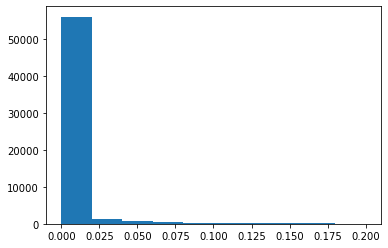

In [ ]:
plt.hist(train_entropies.cpu().numpy(), range=[0, 0.2])

In [ ]:
60000-len(torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy())

5678

In [ ]:
# exports


@dataclass
class Experiment:
    seed: int = 1337
    acquisition_size: int = 5
    max_training_set: int = 300
    num_pool_samples: int = 20
    num_validation_samples: int = 20
    num_training_samples: int = 1
    num_patience_epochs: int = 5 * 4
    max_training_epochs: int = 30 * 4
    training_batch_size: int = 64
    device: str = "cuda"
    validation_set_size: int = 1024
    initial_training_set_size: int = 20
    min_samples_per_epoch: int = 1024
    repeated_mnist_repetitions: int = 1
    add_dataset_noise: bool = False
    acquisition_function: Union[
        Type[CandidateBatchComputer], Type[EvalModelBatchComputer]
    ] = batchbald_redux.acquisition_functions.bald.BALD
    train_eval_model: TrainEvalModel = TrainSelfDistillationEvalModel
    model_optimizer_factory: Type[ModelOptimizerFactory] = MnistOptimizerFactory
    acquisition_function_args: dict = None
    temperature: float = 0.0

    def load_dataset(self) -> (ActiveLearningData, Dataset, Dataset):
        train_dataset = NamedDataset(
            FastMNIST("data", train=True, download=True, device=self.device), "FastMNIST (train)"
        )
        train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location=self.device)

        train_dataset = train_dataset.override_targets(targets=train_predictions.argmax(dim=1))

        train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

        allowed_indices = torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy()
        print(f"Removing {len(train_dataset) - len(allowed_indices)} training samples with entropy >= 0.01.")

        train_dataset = train_dataset.subset(allowed_indices)

        # If we over-sample the train set, we do so after picking the initial train set to avoid duplicates.
        if self.repeated_mnist_repetitions < 1:
            train_dataset = train_dataset * self.repeated_mnist_repetitions

        num_classes = train_dataset.get_num_classes()
        initial_samples_per_class = self.initial_training_set_size // num_classes
        initial_training_set_indices = get_balanced_sample_indices(
            targets=train_dataset.get_targets(),
            num_classes=num_classes,
            samples_per_class=initial_samples_per_class,
            seed=0,
        )

        # If we over-sample the train set, we do so after picking the initial train set to avoid duplicates.
        if self.repeated_mnist_repetitions > 1:
            train_dataset = train_dataset * self.mnist_repetitions

        if self.add_dataset_noise:
            train_dataset = AdditiveGaussianNoise(train_dataset, 0.1)

        active_learning_data = ActiveLearningData(train_dataset)

        active_learning_data.acquire(initial_training_set_indices)

        validation_dataset = active_learning_data.extract_dataset_from_pool(self.validation_set_size)
        validation_dataset = NamedDataset(
            validation_dataset, f"FastMNIST (validation, {len(validation_dataset)} samples)"
        )

        test_dataset = FastMNIST("data", train=False, device=None)
        test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

        return active_learning_data, validation_dataset, test_dataset, initial_training_set_indices

    # Simple Dependency Injection
    def create_acquisition_function(self):
        di = DependencyInjection(vars(self))
        return di.create_dataclass_type(self.acquisition_function)

    def create_train_eval_model(self, runtime_config) -> TrainEvalModel:
        config = {**vars(self), **runtime_config}
        di = DependencyInjection(config, [])
        return di.create_dataclass_type(self.train_eval_model)

    def run(self, store):
        torch.manual_seed(self.seed)

        # Active Learning setup
        active_learning_data, validation_dataset, test_dataset, initial_training_set_indices = self.load_dataset()
        store["initial_training_set_indices"] = initial_training_set_indices
        store["dataset_info"] = dict(training=repr(active_learning_data.base_dataset), test=repr(test_dataset))

        # initial_training_set_indices = active_learning_data.get_random_pool_indices(self.initial_set_size)
        # initial_training_set_indices = get_balanced_sample_indices(
        #     active_learning_data.pool_dataset, 10, self.initial_set_size // 10
        # )

        train_loader = torch.utils.data.DataLoader(
            active_learning_data.training_dataset,
            batch_size=64,
            sampler=RandomFixedLengthSampler(active_learning_data.training_dataset, self.min_samples_per_epoch),
            drop_last=True,
        )
        pool_loader = torch.utils.data.DataLoader(
            active_learning_data.pool_dataset, batch_size=128, drop_last=False, shuffle=False
        )

        validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, drop_last=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, drop_last=False)

        store["active_learning_steps"] = []
        active_learning_steps = store["active_learning_steps"]

        acquisition_function = self.create_acquisition_function()

        # Active Training Loop
        while True:
            training_set_size = len(active_learning_data.training_dataset)
            print(f"Training set size {training_set_size}:")

            # iteration_log = dict(training={}, pool_training={}, evaluation_metrics=None, acquisition=None)
            active_learning_steps.append({})
            iteration_log = active_learning_steps[-1]

            iteration_log["training"] = {}

            model_optimizer = self.model_optimizer_factory().create_model_optimizer()

            double_snapshots = None
            if training_set_size > 0:
                train(
                    model=model_optimizer.model,
                    optimizer=model_optimizer.optimizer,
                    training_samples=self.num_training_samples,
                    validation_samples=self.num_validation_samples,
                    train_loader=train_loader,
                    validation_loader=validation_loader,
                    patience=self.num_patience_epochs,
                    max_epochs=self.max_training_epochs,
                    device=self.device,
                    training_log=iteration_log["training"],
                    wandb_key_path="training",
                )

            evaluation_metrics = evaluate_old(
                model=model_optimizer.model,
                num_samples=self.num_validation_samples,
                loader=test_loader,
                device=self.device,
            )
            iteration_log["evaluation_metrics"] = evaluation_metrics
            print(f"Perf after training {evaluation_metrics}")

            if training_set_size >= self.max_training_set:
                print("Done.")
                break

            trained_model = TrainedBayesianModel(model=model_optimizer.model)

            if isinstance(acquisition_function, CandidateBatchComputer):
                candidate_batch = acquisition_function.compute_candidate_batch(trained_model, pool_loader, self.device)
            elif isinstance(acquisition_function, EvalModelBatchComputer):
                current_max_epochs = iteration_log["training"]["best_epoch"]

                train_eval_model = self.create_train_eval_model(
                    dict(
                        max_epochs=current_max_epochs,
                        training_dataset=active_learning_data.training_dataset,
                        eval_dataset=active_learning_data.pool_dataset,
                        validation_loader=validation_loader,
                        trained_model=trained_model,
                    )
                )

                iteration_log["eval_training"] = {}
                trained_eval_model = train_eval_model(training_log=iteration_log["eval_training"], device=self.device)

                candidate_batch = acquisition_function.compute_candidate_batch(
                    trained_model, trained_eval_model, pool_loader, device=self.device
                )
            else:
                raise ValueError(f"Unknown acquisition function {acquisition_function}!")

            candidate_global_indices = [
                get_base_dataset_index(active_learning_data.pool_dataset, index).index
                for index in candidate_batch.indices
            ]
            candidate_labels = [
                get_target(active_learning_data.pool_dataset, index).item() for index in candidate_batch.indices
            ]

            iteration_log["acquisition"] = dict(
                indices=candidate_global_indices, labels=candidate_labels, scores=candidate_batch.scores
            )

            active_learning_data.acquire(candidate_batch.indices)

            ls = ", ".join(f"{label} ({score:.4})" for label, score in zip(candidate_labels, candidate_batch.scores))
            print(f"Acquiring (label, score)s: {ls}")

In [ ]:
# experiment

experiment = Experiment(
    seed=1120,
    max_training_set=100,
    acquisition_function=acquisition_functions.CoreSetBALD,
    acquisition_size=1,
    initial_training_set_size=20,
    num_pool_samples=100,
    temperature=8,
    device="cuda",
)

results = {}
experiment.run(results)

In [ ]:
results

{'initial_training_set_indices': [46377,
  44390,
  7485,
  25450,
  12220,
  43112,
  3612,
  54256,
  44467,
  17555,
  4218,
  45101,
  41296,
  32261,
  3281,
  6944,
  7701,
  30692,
  24891,
  24436],
 'dataset_info': {'training': "'FastMNIST (train)' | replace_targets{'targets': tensor([5, 0, 4,  ..., 5, 6, 8], device='cuda:0'), 'num_classes': 10}[[    1     2     3 ... 59997 59998 59999]]",
  'test': "'FastMNIST (test, 10000 samples)'"},
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.4912109375,
      'crossentropy': 1.6887787580490112},
     {'accuracy': 0.58984375, 'crossentropy': 1.3072025775909424},
     {'accuracy': 0.5654296875, 'crossentropy': 1.4302316904067993},
     {'accuracy': 0.60546875, 'crossentropy': 1.394342064857483},
     {'accuracy': 0.587890625, 'crossentropy': 1.4962290525436401},
     {'accuracy': 0.607421875, 'crossentropy': 1.4129021167755127},
     {'accuracy': 0.5986328125, 'crossentropy': 1.4781932830810547},
     {'accuracy': 0.5

In [ ]:
results["initial_training_set_indices"]

[46377,
 44390,
 7485,
 25450,
 12220,
 43112,
 3612,
 54256,
 44467,
 17555,
 4218,
 45101,
 41296,
 32261,
 3281,
 6944,
 7701,
 30692,
 24891,
 24436]

In [ ]:
results["initial_training_set_indices"] + [step["acquisition"]["indices"][0] for step in results["active_learning_steps"] if "acquisition" in step]

[46377,
 44390,
 7485,
 25450,
 12220,
 43112,
 3612,
 54256,
 44467,
 17555,
 4218,
 45101,
 41296,
 32261,
 3281,
 6944,
 7701,
 30692,
 24891,
 24436,
 17776,
 36852,
 26891,
 17001,
 44414,
 23050,
 30884,
 41516,
 8897,
 34608,
 11721,
 13127,
 9870,
 39700,
 13985,
 9608,
 17808,
 23028,
 3494,
 10210,
 42384,
 31742,
 17100,
 46530,
 26733,
 4762,
 14113,
 20798,
 28388,
 42973,
 37347,
 55042,
 41295,
 28310,
 19280,
 18501,
 274,
 11208,
 13335,
 24440,
 49493,
 58129,
 56210,
 40766,
 13318,
 50040,
 18408,
 7255,
 15494,
 7168,
 9472,
 14845,
 14096,
 26072,
 35944,
 34836,
 12655,
 991,
 38577,
 47322,
 45212,
 16286,
 5308,
 38182,
 31624,
 12702,
 30861,
 46320,
 36408,
 49841,
 33426,
 57527,
 3273,
 24740,
 39627,
 22199,
 19362,
 42136,
 41965,
 43095]

In [ ]:
[step["evaluation_metrics"]["accuracy"] for step in results["active_learning_steps"]]

[0.6133,
 0.6389,
 0.623,
 0.6992,
 0.7246,
 0.6774,
 0.7303,
 0.6868,
 0.6948,
 0.7454,
 0.745,
 0.7372,
 0.7409,
 0.7068,
 0.7204,
 0.8036,
 0.7384,
 0.8092,
 0.7566,
 0.8125,
 0.8207,
 0.8281,
 0.8316,
 0.8135,
 0.8137,
 0.8438,
 0.8346,
 0.853,
 0.8159,
 0.8131,
 0.7874,
 0.8414,
 0.8722,
 0.8429,
 0.8414,
 0.8343,
 0.8303,
 0.8739,
 0.8655,
 0.8654,
 0.8516,
 0.8697,
 0.8491,
 0.8507,
 0.8418,
 0.8628,
 0.8791,
 0.8809,
 0.9069,
 0.9001,
 0.9123,
 0.8917,
 0.8485,
 0.8767,
 0.8817,
 0.8766,
 0.8775,
 0.8798,
 0.9062,
 0.9059,
 0.8746,
 0.8927,
 0.8789,
 0.8968,
 0.8964,
 0.8817,
 0.9022,
 0.8723,
 0.9006,
 0.9189,
 0.9328,
 0.9189,
 0.9343,
 0.934,
 0.9328,
 0.9358,
 0.935,
 0.9045,
 0.9361,
 0.9438,
 0.929]

In [ ]:
# experiment

experiment = Experiment(
    seed=1120,
    max_training_epochs=50,
    num_patience_epochs=20,
    max_training_set=80,
    acquisition_function=acquisition_functions.CoreSetBALD,
    acquisition_size=1,
    num_pool_samples=20,
    initial_training_set_size=20,
    temperature=8,
    min_samples_per_epoch=1000,
    device="cuda",
)

results = {}
experiment.run(results)

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Removing 5678 training samples with entropy >= 0.01.
Creating: CoreSetBALD(
	acquisition_size=1,
	num_pool_samples=20
)
Training set size 20:


TypeError: train() missing 1 required keyword-only argument: 'wandb_key_path'

In [ ]:
results

{'initial_training_set_indices': [38043,
  40091,
  17418,
  2094,
  39879,
  3133,
  5011,
  40683,
  54379,
  24287,
  9849,
  59305,
  39508,
  39356,
  8758,
  52579,
  13655,
  7636,
  21562,
  41329],
 'dataset_info': {'training': "'FastMNIST (Train)'",
  'test': "'FastMNIST (Test)'"},
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.62109375,
      'crossentropy': 2.6530187726020813},
     {'accuracy': 0.6376953125, 'crossentropy': 2.762658029794693},
     {'accuracy': 0.646484375, 'crossentropy': 3.056214064359665},
     {'accuracy': 0.6416015625, 'crossentropy': 3.1257119178771973}],
    'best_epoch': 1},
   'evaluation_metrics': {'accuracy': 0.631,
    'crossentropy': 2.6251225173950195}}]}

In [ ]:
# experiment

experiment = Experiment(
    max_training_epochs=1, max_training_set=25, acquisition_function=AcquisitionFunction.randombaldical
)

results = {}
experiment.run(results)

results

Training set size 20:


100%|##########| 1/1 [00:00<?, ?it/s]

[1/384]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -6.529030114412308)
RestoringEarlyStopping: Restoring optimizer.


[1/157]   1%|           [00:00<?]

Perf after training {'accuracy': 0.5367, 'crossentropy': 6.438035237884521}


get_predictions:   0%|          | 0/463616 [00:00<?, ?it/s]

100%|##########| 1/1 [00:00<?, ?it/s]

[1/1811]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -5.1637596152722836)
RestoringEarlyStopping: Restoring optimizer.


get_predictions:   0%|          | 0/2317680 [00:00<?, ?it/s]

get_predictions:   0%|          | 0/2317680 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Entropy:   0%|          | 0/115884 [00:00<?, ?it/s]

Acquiring (label, score)s: 8 (0.8711), 8 (0.8687), 3 (0.876), 3 (0.8465), 3 (0.8811)
Training set size 25:


100%|##########| 1/1 [00:00<?, ?it/s]

[1/384]   0%|           [00:00<?]

[1/64]   2%|1          [00:00<?]

RestoringEarlyStopping: Restoring best parameters. (Score: -4.6851686127483845)
RestoringEarlyStopping: Restoring optimizer.


[1/157]   1%|           [00:00<?]

Perf after training {'accuracy': 0.6256, 'crossentropy': 4.484497045135498}
Done.


{'initial_training_set_indices': [38043,
  40091,
  17418,
  2094,
  39879,
  3133,
  5011,
  40683,
  54379,
  24287,
  9849,
  59305,
  39508,
  39356,
  8758,
  52579,
  13655,
  7636,
  21562,
  41329],
 'active_learning_steps': [{'training': {'epochs': [{'accuracy': 0.538818359375,
      'crossentropy': 6.529030114412308}],
    'best_epoch': 1},
   'evalution_metrics': {'accuracy': 0.5367,
    'crossentropy': 6.438035237884521},
   'pool_training': {'epochs': [{'accuracy': 0.531005859375,
      'crossentropy': 5.1637596152722836}],
    'best_epoch': 1},
   'acquisition': {'indices': [63338, 10856, 63452, 81864, 109287],
    'labels': [8, 8, 3, 3, 3],
    'scores': [0.8710822958846325,
     0.8687216999221631,
     0.8759664372823723,
     0.8464646732511746,
     0.8810812784952251]}},
  {'training': {'epochs': [{'accuracy': 0.62255859375,
      'crossentropy': 4.6851686127483845}],
    'best_epoch': 1},
   'evalution_metrics': {'accuracy': 0.6256,
    'crossentropy': 4.4844970451

In [ ]:
# exports

configs = [
    Experiment(
        seed=seed,
        acquisition_function=acquisition_function,
        acquisition_size=acquisition_size,
        num_pool_samples=num_pool_samples,
        initial_training_set_size=20,
        max_training_set=160,
        temperature=8,
    )
    for seed in range(10)
    for acquisition_function in [
        batchbald_redux.acquisition_functions.coreset.BatchCoreSetBALD
    ]
    for acquisition_size in [5]
    for num_pool_samples in [100]
]

if not is_run_from_ipython() and __name__ == "__main__":
    for job_id, store in embedded_experiments(__file__, len(configs)):
        config = configs[job_id]
        config.seed += job_id
        print(config)
        store["config"] = dataclasses.asdict(config)
        store["log"] = {}

        try:
            config.run(store=store)
        except Exception:
            store["exception"] = traceback.format_exc()
            raise

In [ ]:
len(configs)

10

In [ ]:
# slow
import prettyprinter

prettyprinter.install_extras(include={"dataclasses"})

prettyprinter.pprint(configs)

[
    Experiment(
        seed=0,
        max_training_set=140,
        num_pool_samples=100,
        # class
        acquisition_function=batchbald_redux.acquisition_functions.BatchCoreSetBALD,
        temperature=8
    ),
    Experiment(
        seed=1,
        max_training_set=140,
        num_pool_samples=100,
        # class
        acquisition_function=batchbald_redux.acquisition_functions.BatchCoreSetBALD,
        temperature=8
    ),
    Experiment(
        seed=2,
        max_training_set=140,
        num_pool_samples=100,
        # class
        acquisition_function=batchbald_redux.acquisition_functions.BatchCoreSetBALD,
        temperature=8
    ),
    Experiment(
        seed=3,
        max_training_set=140,
        num_pool_samples=100,
        # class
        acquisition_function=batchbald_redux.acquisition_functions.BatchCoreSetBALD,
        temperature=8
    ),
    Experiment(
        seed=4,
        max_training_set=140,
        num_pool_samples=100,
        # class
  